In [1]:
import sys
import numpy as np 
import pandas as pd 
from collections import Counter

import cornac
from cornac.models.ncf.recom_mlp import MLP
from cornac.eval_methods import RatioSplit
from cornac.data.dataset import Dataset
from cornac.utils import cache

from recommenders.utils.timer import Timer
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking, predict

import matplotlib.pyplot as plt 
import seaborn as sns

FM model is only supported on Linux.
Windows executable can be found at http://www.libfm.org.


In [2]:
SEED = 42
VERBOSE = True

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

System version: 3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]
Cornac version: 1.14.1


---
Load Datasets

In [3]:
user_df = pd.read_csv('../data/ml_100k/user_data.csv')
user_df.head()

,id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [4]:
item_df = pd.read_csv('../data/ml_100k/item_data.csv')
item_df.head()

,id,title,release_date,video_release_date,url,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [5]:
train_df = pd.read_csv('../data/ml_100k/train_data.csv')
train_df.head()

,user_id,item_id,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [6]:
test_df = pd.read_csv('../data/ml_100k/test_data.csv')
test_df.head()

,user_id,item_id,rating,timestamp
0,1,6,5,887431973
1,1,10,3,875693118
2,1,12,5,878542960
3,1,14,5,874965706
4,1,17,3,875073198


In [7]:
# chronological splitting
train_df, val_df = python_chrono_split(train_df,
                                        ratio=0.8,
                                        min_rating=10,
                                        filter_by='user',
                                        col_user='user_id',
                                        col_item='item_id',
                                        col_timestamp='timestamp')

In [8]:
train_dt = cornac.data.Dataset.from_uir(train_df.loc[:, ['user_id', 'item_id', 'rating']].itertuples(index=False), seed=SEED)
val_dt = cornac.data.Dataset.from_uir(val_df.loc[:, ['user_id', 'item_id', 'rating']].itertuples(index=False), seed=SEED)

In [9]:
# train a SVD model

model = cornac.models.SVD(
    k=32,
    max_iter=100,
    learning_rate=0.001,
    lambda_reg=0.0001,
    early_stop=True,
    num_threads=0,
    verbose=True,
    seed=123
)

In [10]:
with Timer() as t:
    model.fit(train_dt, val_set=val_dt)
print("Took {} seconds for training.".format(t))

100%|██████████| 100/100 [00:00<00:00, 264.89it/s, loss=26107.08]

Optimization finished!
Took 0.3874 seconds for training.


In [14]:
# model prediction for the test dataset transactions
model_predictions = predict(model, test_df, usercol='user_id', itemcol='item_id')
model_predictions.head()

,user_id,item_id,prediction
0,1,6,3.620788397768936
1,1,10,3.9310578348007565
2,1,12,4.4975073910676455
3,1,14,3.983257289080373
4,1,17,3.3488390937340027


In [16]:
model_predictions['score'] = model_predictions['prediction'].apply(lambda x: np.round(x)).astype(np.int32) ## type matching between test rating and prediction ratings
model_predictions.head()

,user_id,item_id,prediction,rating,score
0,1,6,3.620788397768936,4,4
1,1,10,3.9310578348007565,4,4
2,1,12,4.4975073910676455,4,4
3,1,14,3.983257289080373,4,4
4,1,17,3.3488390937340027,3,3


In [17]:
res_df = pd.concat([
    model_predictions.loc[:, ['user_id', 'item_id', 'score']],
    test_df.loc[:, ['rating', 'timestamp']]
], axis=1)
res_df.head()

,user_id,item_id,score,rating,timestamp
0,1,6,4,5,887431973
1,1,10,4,3,875693118
2,1,12,4,5,878542960
3,1,14,4,5,874965706
4,1,17,3,3,875073198


In [18]:
res_df.to_csv('../data/ml_100k/predicted_data.csv', index=False)

In [13]:
# model prediction for all user-item combination
all_items = train_df['item_id'].unique()
num_items = train_df['item_id'].nunique()
all_users = train_df['user_id'].unique()
cmp_test_df = []
for u in all_users:
    user_sub = train_df.loc[train_df['user_id']==u, :]['item_id'].unique()
    cmp_test_df.append(pd.DataFrame({'user_id': [u,]*num_items, 'item_id': all_items,  'subscription_status': np.in1d(all_items, user_sub)}))
cmp_test_df = pd.concat(cmp_test_df, axis=0)
print(cmp_test_df.shape)
cmp_test_df.head()

(1478586, 3)


,user_id,item_id,subscription_status
0,1,172,True
1,1,168,True
2,1,165,True
3,1,156,True
4,1,166,True


In [98]:
all_preds = predict(model, cmp_test_df, usercol='user_id', itemcol='item_id')
all_preds['rating'] = all_preds['prediction'].apply(lambda x: np.round(x)).astype(np.int32)
all_preds['sub_status'] = cmp_test_df['subscription_status'].values
all_preds.head()

,user_id,item_id,prediction,rating,sub_status
0,1,172,4.256668631721712,4,True
1,1,168,4.09649690267486,4,True
2,1,165,4.190786533326334,4,True
3,1,156,3.9683818293627864,4,True
4,1,166,4.0987999306884175,4,True


---
Metrics dynamics with the prediction set size

In [13]:
# top k items to recommend
TOP_K = 10

eval_map = map_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)
eval_ndcg = ndcg_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)
eval_precision = precision_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)
eval_recall = recall_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)

print(f"MAP@{TOP_K}:\t{eval_map}",
      f"NDCG@{TOP_K}:\t{eval_ndcg}",
      f"Precision@{TOP_K}:\t{eval_precision}",
      f"Recall@{TOP_K}:\t{eval_recall}", sep='\n')

MAP@10:	0.4848842973958476
NDCG@10:	1.0
Precision@10:	0.9374727668845315
Recall@10:	0.4848842973958476


In [14]:
# top k items to recommend
TOP_K = 25

eval_map = map_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)
eval_ndcg = ndcg_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)
eval_precision = precision_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)
eval_recall = recall_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)

print(f"MAP@{TOP_K}:\t{eval_map}",
      f"NDCG@{TOP_K}:\t{eval_ndcg}",
      f"Precision@{TOP_K}:\t{eval_precision}",
      f"Recall@{TOP_K}:\t{eval_recall}", sep='\n')

MAP@25:	0.7301226090027855
NDCG@25:	1.0
Precision@25:	0.7535511982570807
Recall@25:	0.7301226090027855


In [15]:
# top k items to recommend
TOP_K = 50

eval_map = map_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)
eval_ndcg = ndcg_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)
eval_precision = precision_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)
eval_recall = recall_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=TOP_K)

print(f"MAP@{TOP_K}:\t{eval_map}",
      f"NDCG@{TOP_K}:\t{eval_ndcg}",
      f"Precision@{TOP_K}:\t{eval_precision}",
      f"Recall@{TOP_K}:\t{eval_recall}", sep='\n')

MAP@50:	0.8715976563571681
NDCG@50:	1.0
Precision@50:	0.572156862745098
Recall@50:	0.8715976563571681


In [16]:
# calc. number of items per user in the test dataset
alt_df1 = test_df.groupby('user_id')['item_id'].count().reset_index()
print(f"Number of items per user vary from the {alt_df1['item_id'].min()} to {alt_df1['item_id'].max()}")

Number of items per user vary from the 1 to 263


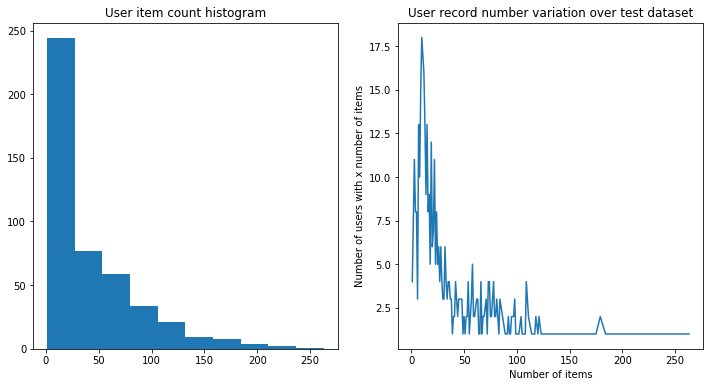

In [17]:
c = dict(Counter(alt_df1['item_id']))
c = dict(sorted(c.items(), key=lambda item: item[0]))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("User item count histogram")
plt.hist(alt_df1['item_id'])

plt.subplot(1, 2, 2)
plt.plot(list(c.keys()), list(c.values()))
plt.title("User record number variation over test dataset")
plt.ylabel("Number of users with x number of items")
plt.xlabel("Number of items")
plt.show()

In [18]:
# record the metrics value variation with K value
ks = [5, 10, 15, 25, 40, 50, 100]
data_dict = {'value': [], 'metrics': [], 'k': []}
for k in ks:
    eval_map = map_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=k)
    eval_ndcg = ndcg_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=k)
    eval_precision = precision_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=k)
    eval_recall = recall_at_k(test_df, model_predictions, col_prediction='rating', col_rating='rating', col_item='item_id', col_user='user_id', k=k)
    data_dict['value'].extend([eval_map, eval_ndcg, eval_precision, eval_recall])
    data_dict['metrics'].extend(['map', 'ndgc', 'precision', 'recall'])
    data_dict['k'].extend([k, k, k, k])
eval_result_df = pd.DataFrame(data_dict)

In [19]:
eval_result_df.head()

,value,metrics,k
0,0.288998,map,5
1,1.000000,ndgc,5
2,0.979956,precision,5
3,0.288998,recall,5
4,0.484884,map,10


<AxesSubplot:xlabel='k', ylabel='value'>

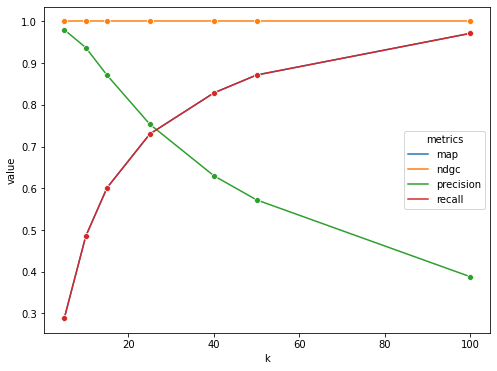

In [20]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=eval_result_df, x='k', y='value', hue='metrics', marker='o')

---
Pre & Post Prediction Item popularity visualization

In [72]:
# train time item popularity 
item_c = train_df.groupby('item_id')['user_id'].count()
count_dict = item_c.value_counts(ascending=False).to_dict()
srt_dict = {k: v for k, v in sorted(count_dict.items(), key=lambda item: item[0])}

In [73]:
# test time item popularity
item_ct = test_df.groupby('item_id')['user_id'].count()
count_dictt = item_ct.value_counts(ascending=False).to_dict()
srt_dictt = {k: v for k, v in sorted(count_dictt.items(), key=lambda item: item[0])}

In [108]:
# prediction time item popularity
srt_pred_df = all_preds.loc[all_preds['sub_status']==False, :].sort_values(by='prediction', ascending=False)
top5_preds = srt_pred_df.groupby('user_id').head(15)
print(top5_preds.shape)

item_cp = top5_preds.groupby('item_id')['user_id'].count()
count_dictp = item_cp.value_counts(ascending=False).to_dict()
srt_dictp = {k: v for k, v in sorted(count_dictp.items(), key=lambda item: item[0])}

(14055, 5)


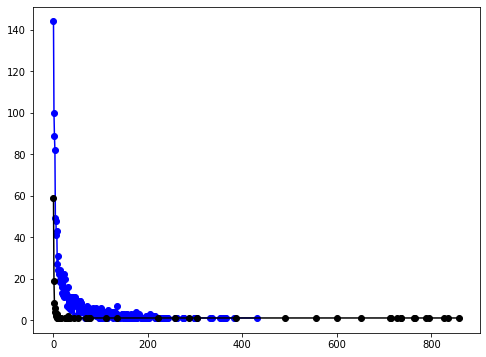

In [109]:
plt.figure(figsize=(8, 6))
plt.plot(list(srt_dict.keys()), list(srt_dict.values()), marker='o', color='blue')
plt.plot(list(srt_dictp.keys()), list(srt_dictp.values()), marker='o', color='black')

In [110]:
def predictTopK(model, dataset, user_col, item_col, k=10):
    preds = predict(model, dataset, usercol=user_col, itemcol=item_col)
    srt_preds = preds.sort_values(by='prediction', ascending=False)
    topK_preds = srt_preds.groupby(user_col).head(k)
    return topK_preds

In [20]:
from recommenders.evaluation.python_evaluation import catalog_coverage, distributional_coverage

catalog_coverage(train_df, test_df, col_user='user_id', col_item='item_id')
distributional_coverage(train_df, test_df, col_user='user_id', col_item='item_id')

9.68472564107168